# Bias Mitigation in Automated Loan Eligibility Process
**@authors: Chiara Angileri, Niccolò Marzi, Shola Oshodi** 

The dataset can be found in this link: https://www.kaggle.com/datasets/burak3ergun/loan-data-set/code?datasetId=74581

In [142]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score

from scipy.stats import chi2_contingency

import fairlearn.metrics as flm

import warnings
warnings.filterwarnings("ignore")

## 1. Dataset inspection and preparation

In [99]:
# Import the dataset
df = pd.read_csv('loan_data_set.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


**Dataset Description:**

| Variable | Description | 
|------|------|
| Loan_ID | Unique Loan ID | 
| Gender | Male/ Female | 
| Married | Applicant married (Y/N) | 
| Dependents | Number of dependents | 
| Education | Applicant Education (Graduate/ Under Graduate) | 
| Self_Employed | Self employed (Y/N) | 
| ApplicantIncome | Applicant income | 
| CoapplicantIncome | Coapplicant income | 
| LoanAmount | Loan amount in thousands | 
| Loan_Amount_Term | Term of loan in months | 
| Credit_History | Whether the credit history meets guidelines | 
| Property_Area | Urban/ Semi Urban/ Rural | 
| Loan_Status | Loan approved (Y/N) | 


There are 615 observations in this dataset.

### 1.1 Inspection

We will now investigate the dataset data distribution

In [100]:
def plot_column_distributions(data, palette='husl', type='discrete'):
    num_columns = data.shape[1]
    num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed for the subplots grid
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 4 * num_rows))  # Create subplots grid
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, column in enumerate(data.columns):
        ax = axes[i]
        if type == 'discrete':
            sns.countplot(x=data[column], palette=palette, ax=ax)
            ax.set_xlabel('Categories')
            ax.set_xlabel('Distribution of ' + column)
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45)
            # Add counts above the bars
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', color='black', xytext=(0, 5),
                            textcoords='offset points')
        else:
            sns.boxplot(x=data[column], color=palette[i], ax=ax, orient='V')
            ax.set_ylabel('Values')
            ax.set_xlabel('Distribution of ' + column)
            # Add gridlines
            ax.yaxis.grid(True)
            # Remove the top and right spines
            sns.despine(ax=ax)
            
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

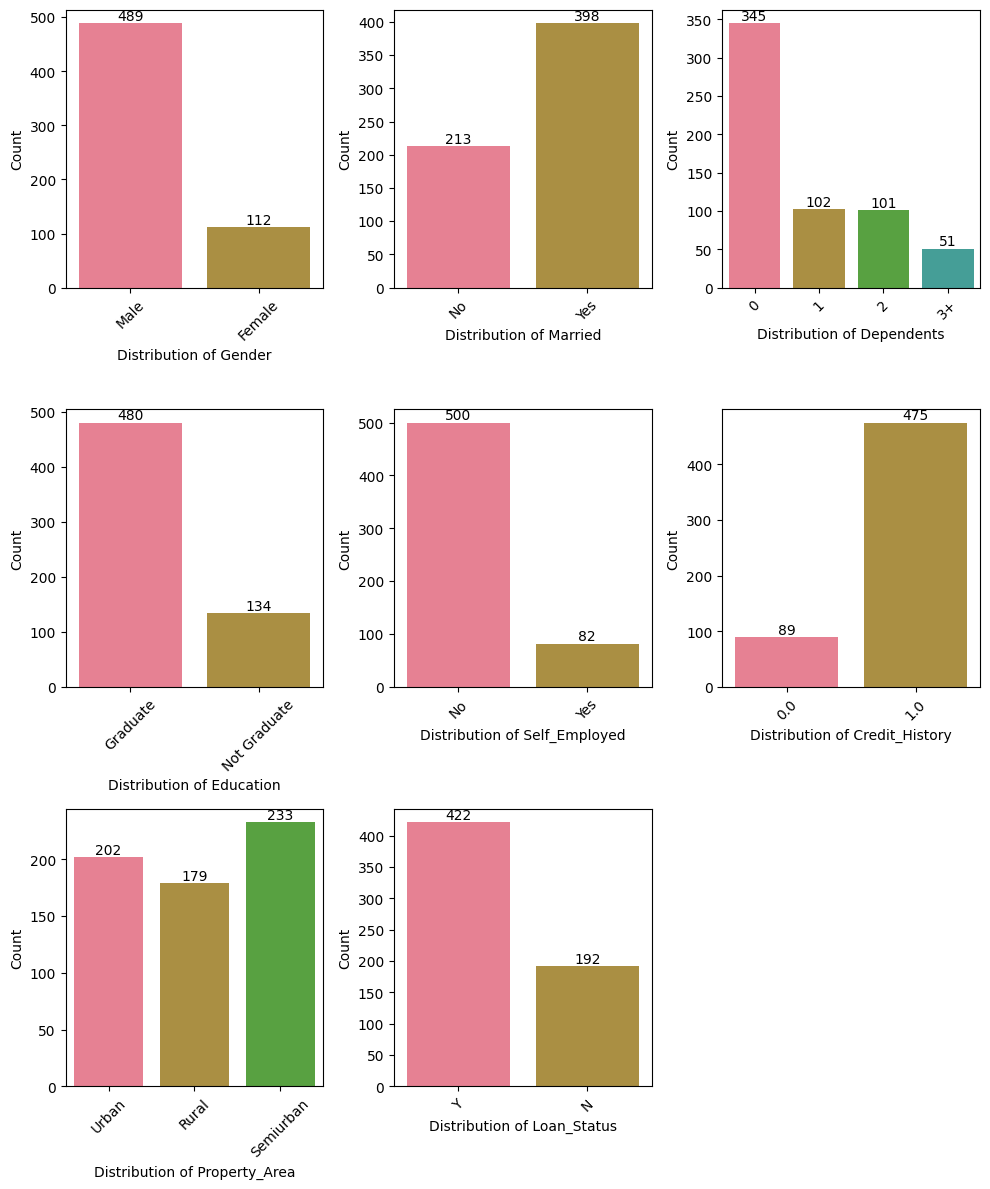

In [101]:
palette = sns.color_palette("husl")
# Convert float64 to object
df['Credit_History'] = df['Credit_History'].astype('object')
discrete_columns = df.select_dtypes(include=['object']).columns.tolist()[1:]

plot_column_distributions(df[discrete_columns], palette)

- Observing the distributions of the variables, one can notice an imbalance regarding the representation of men and women in the dataset, particularly with men accounting for  79,5% of cases.

- The majority of the subjects examined are married, have a high school diploma, do not have dependents, and are not self-employed.

- Their residential area ownership appears balanced, with a slight predominance of semi-urban areas.

- Regarding the target variable in most of the cases the loan status is positive (68%) as also their credit history 

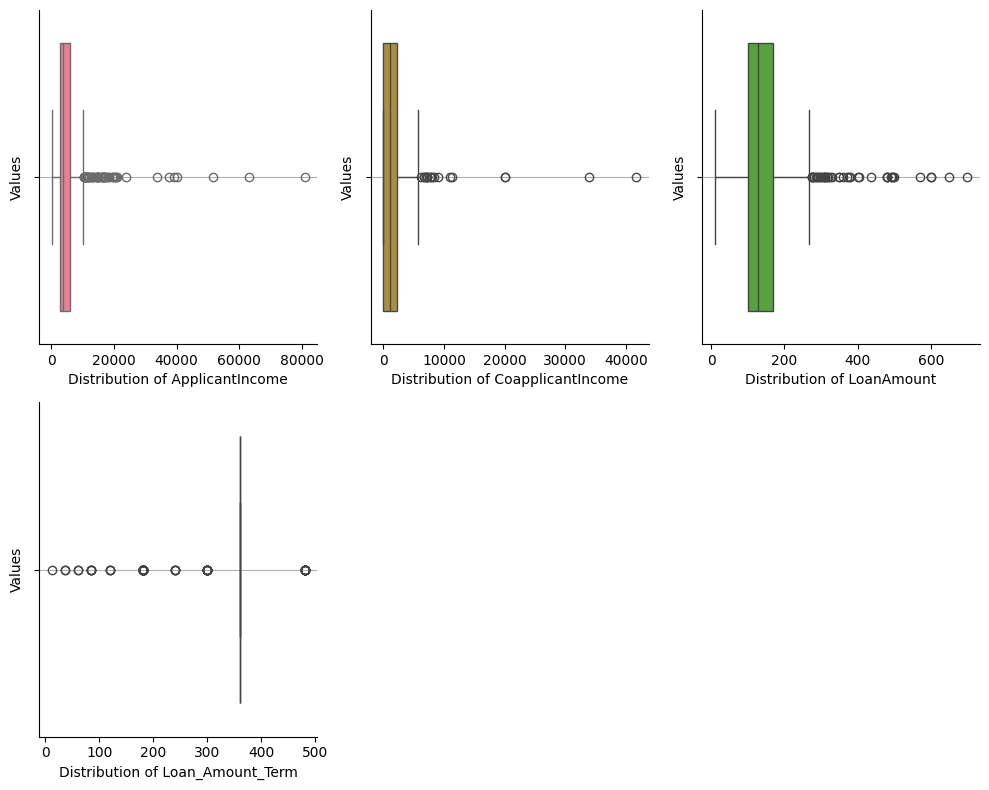

In [102]:
continuos_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
plot_column_distributions(df[continuos_columns], palette, "continue")

In [103]:
df[continuos_columns].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


- Applicants have higher income than the co-applicatants.
- Typically, co-applicants have an average income lower than 10000, but there are cases of higher income, up to 40000.
- The loan amount typically falls within the range of 150000 to 250000, with some loans reaching up to 400000, although higher values are rare.
- The loan term commonly spans around 350 months.

#### 1.1.1. Bivariate Analysis

We can perform Chi-square test to verify the independence of two categorical variables.

**Chi-square test**: statistical method used to determine if there is a significant association between categorical variables. It's widely used in hypothesis testing. 

- *Null Hypothesis (H0)*: There is no association between the categorical variables. In other words, the observed frequencies in each category are consistent with the expected frequencies.
- *Alternative Hypothesis (H1)*: There is an association between the categorical variables. The observed frequencies differ significantly from the expected frequencies.

***Decision Criteria***
- *Reject the Null Hypothesis (H0)*: If the p-value is less than the chosen significance level (e.g., 0.05), it indicates that there is a significant association between the variables, and H0 is rejected in favor of H1.
- *Fail to Reject the Null Hypothesis (H0)*: If the p-value is greater than or equal to the significance level, it indicates that there is not enough evidence to suggest a significant association between the variables, and H0 is not rejected.

In [104]:
def plot_bivariate_relationship(data, x, y, palette='husl'):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=x, hue=y, data=data, palette=palette)
    for p in ax.patches:
        height = p.get_height()
        if height != 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

def chi_square_test(data, x, y, alpha = 0.05):
    contingency_table = pd.crosstab(data[x], data[y])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square test statistic: {chi2}')
    print(f'p-value: {p}')
    print(f'Degrees of freedom: {dof}')
    if p <= alpha:
        print(f'The two variables {x} and {y} are dependent (reject H0).')
    else:
        print(f'The two variables {x} and {y} are independent (fail to reject H0).')

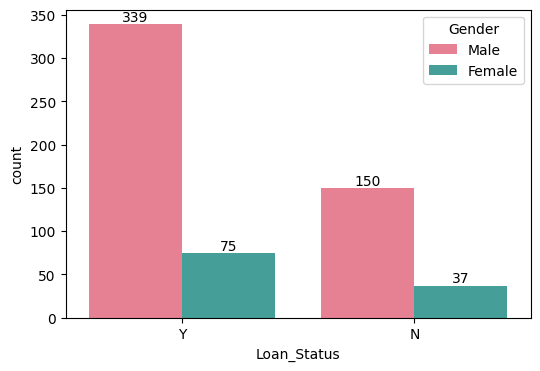

Chi-square test statistic: 0.13962612116543877
p-value: 0.7086529816451106
Degrees of freedom: 1
The two variables Loan_Status and Gender are independent (fail to reject H0).


In [105]:
# Loan status and Gender including 
plot_bivariate_relationship(df, 'Loan_Status', 'Gender')
chi_square_test(df, 'Loan_Status', 'Gender')

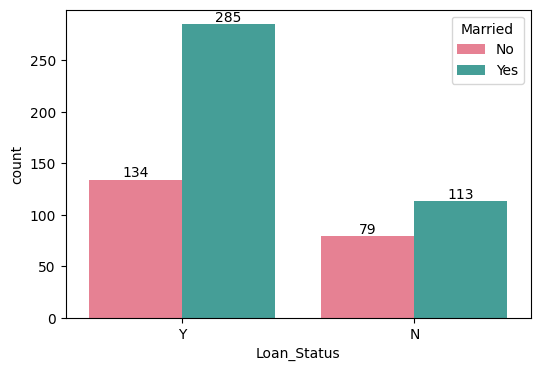

Chi-square test statistic: 4.475019348315097
p-value: 0.03439381301579988
Degrees of freedom: 1
The two variables Loan_Status and Married are dependent (reject H0).


In [106]:
# Loan status and Married
plot_bivariate_relationship(df, 'Loan_Status', 'Married')
chi_square_test(df, 'Loan_Status', 'Married')

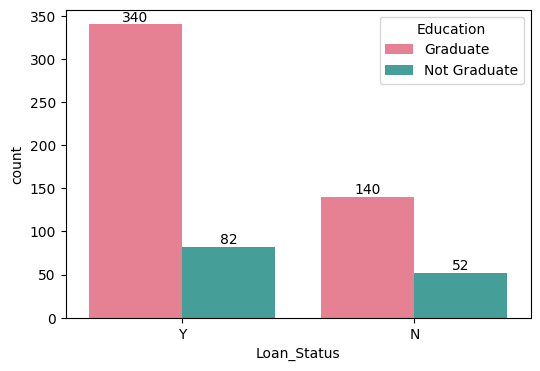

Chi-square test statistic: 4.091490413303621
p-value: 0.043099621293573545
Degrees of freedom: 1
The two variables Loan_Status and Education are dependent (reject H0).


In [107]:
# Loan status and Education
plot_bivariate_relationship(df, 'Loan_Status', 'Education')
chi_square_test(df, 'Loan_Status', 'Education')

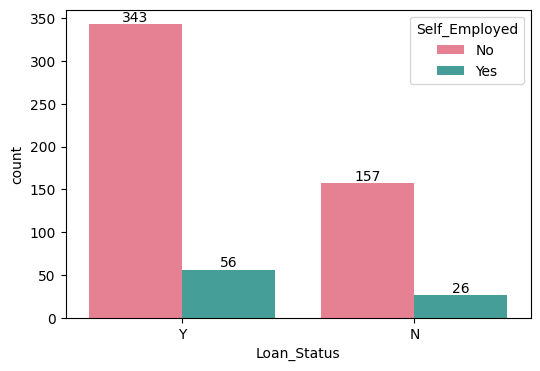

Chi-square test statistic: 0.0
p-value: 1.0
Degrees of freedom: 1
The two variables Loan_Status and Self_Employed are independent (fail to reject H0).


In [108]:
# Loan status and Self_Employed
plot_bivariate_relationship(df, 'Loan_Status', 'Self_Employed')
chi_square_test(df, 'Loan_Status', 'Self_Employed')

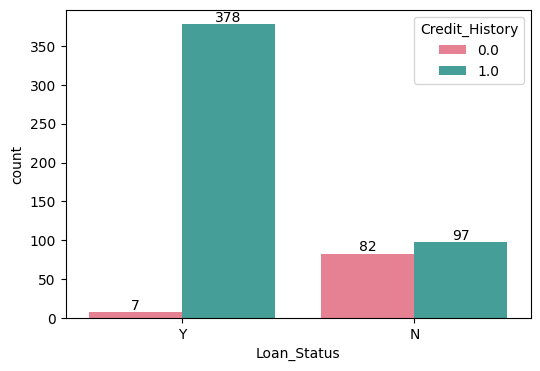

Chi-square test statistic: 174.63729658142535
p-value: 7.184759548750746e-40
Degrees of freedom: 1
The two variables Loan_Status and Credit_History are dependent (reject H0).


In [109]:
# Loan status and Credit_History
plot_bivariate_relationship(df, 'Loan_Status', 'Credit_History')
chi_square_test(df, 'Loan_Status', 'Credit_History')

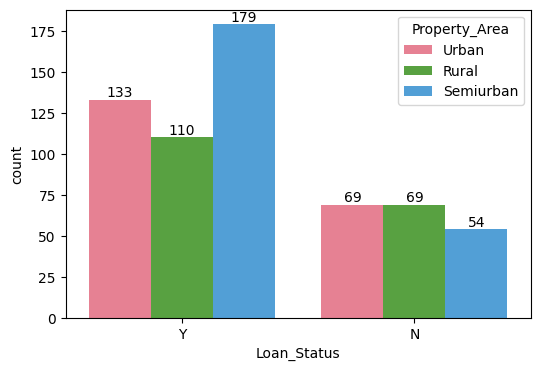

Chi-square test statistic: 12.297623130485677
p-value: 0.0021360187811644915
Degrees of freedom: 2
The two variables Loan_Status and Property_Area are dependent (reject H0).


In [110]:
# Loan status and Property_Area
plot_bivariate_relationship(df, 'Loan_Status', 'Property_Area')
chi_square_test(df, 'Loan_Status', 'Property_Area')


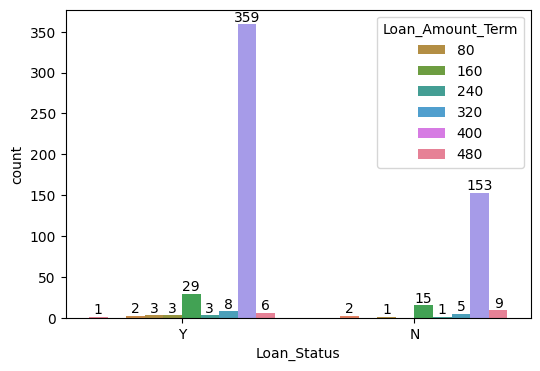

Chi-square test statistic: 14.013166955181328
p-value: 0.12185762421276597
Degrees of freedom: 9
The two variables Loan_Status and Loan_Amount_Term are independent (fail to reject H0).


In [111]:
# Loan status and Loan_Amount_Term
plot_bivariate_relationship(df, 'Loan_Status', 'Loan_Amount_Term')
chi_square_test(df, 'Loan_Status', 'Loan_Amount_Term')

## 1.2 Data Preparation

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    object 
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(9)
memory usage: 62.5+ KB


How many missing values are there?

In [113]:
df.isnull().sum() / df.shape[0] * 100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

Columns that can be dropped:
- Since each record has a different **Loan_ID** it can be dropped.

In [114]:
# Drop irrelevant columns
df.drop(columns=['Loan_ID'], inplace=True)

Since Loan Amount and Loan Term aren't Nan frequently we decided to fill the Nan values with their means when they occur.

In [115]:
df['LoanAmount'].fillna(int(df['LoanAmount'].mean()), inplace=True)
df['Loan_Amount_Term'].fillna(int(df['Loan_Amount_Term'].mean()), inplace=True)

For simplicity, we will drop rows with missing values in **Gender** and **Married**.

In [116]:
df = df[(~df['Gender'].isnull()) & (~df['Married'].isnull())]

For the others we treat them as a separate category.

In [117]:
df['Dependents'] = df['Dependents'].map({'0': '0',
                                         '1': '1',
                                         '2': '2',
                                         '3+': '3'})

fill_values = {'Self_Employed': 'NaN', 'Dependents': 'NaN', 'Credit_History': -1}
df.fillna(value=fill_values, inplace=True)

In [118]:
df.isnull().sum() / df.shape[0] * 100

Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

Now we need to encode the categorical columns.

In [119]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 
                    'Credit_History', 'Property_Area', 'Dependents', 'Loan_Status']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

<Axes: >

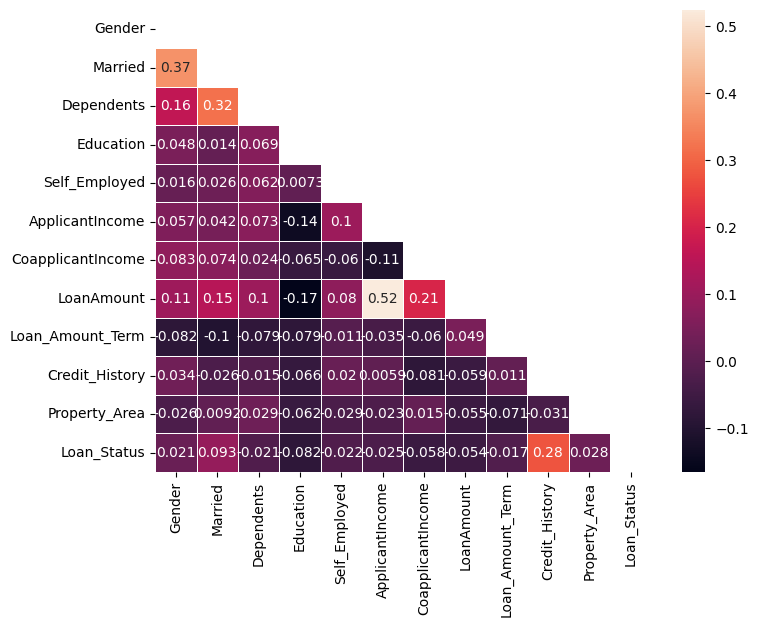

In [120]:
# Categorical variables correlation
matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(df.corr(), annot = True, mask = matrix, linewidths = .5, ax = ax)

For non-binary columns we make the one-hot-encode of them.

In [121]:
non_binary_cols = ['Self_Employed', 'Credit_History', 'Property_Area', 'Dependents']

encoded_features = []
ohe = OneHotEncoder()

for feature in non_binary_cols:
    encoded_feat = OneHotEncoder(drop='first').fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    n = df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(0, n-1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df.index
    encoded_features.append(encoded_df)
    
df = pd.concat([df.drop(columns=non_binary_cols), *encoded_features], axis=1)

In [122]:
df

,Gender,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Dependents_0,Dependents_1,Dependents_2,Dependents_3
0,1,0,0,5849,0.0,146.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,4583,1508.0,128.0,360.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1,0,3000,0.0,66.0,360.0,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,1,2583,2358.0,120.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,0,6000,0.0,141.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,2900,0.0,71.0,360.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
610,1,1,0,4106,0.0,40.0,180.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
611,1,1,0,8072,240.0,253.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
612,1,1,0,7583,0.0,187.0,360.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## 1.3 Dataset Split

In [150]:
# Splitting the dataset into the Training set and Test set
A = df['Gender'] # Sensitive attribute
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=0)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (478, 17)
Test set shape: (120, 17)


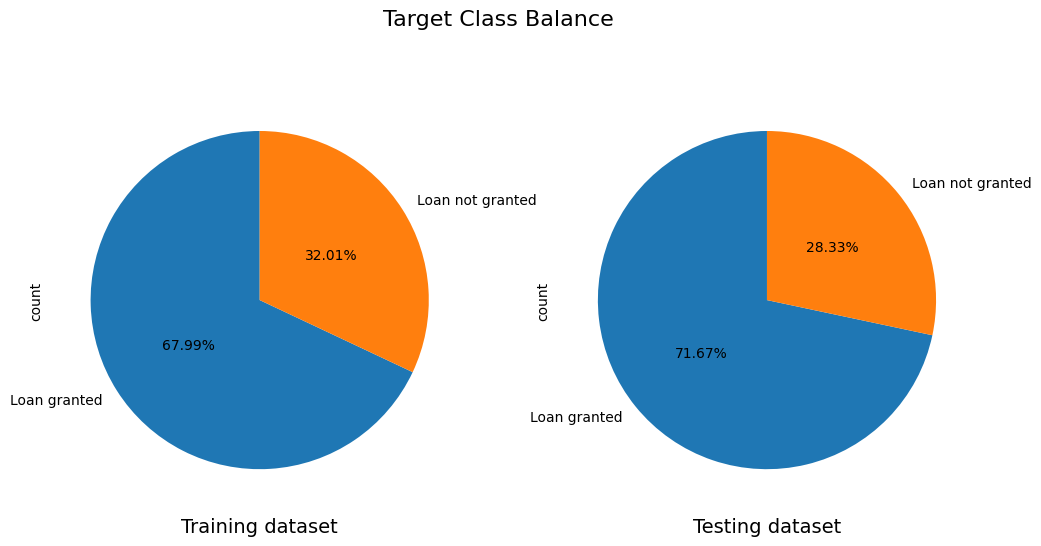

In [151]:
# Train - Test distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind = 'pie',
                            autopct = '%.2f%%',
                            startangle = 90,
                            labels = ['Loan granted', 'Loan not granted'],
                            pctdistance = 0.5)
plt.xlabel('Training dataset', fontsize = 14)

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind = 'pie',
                           autopct = '%.2f%%',
                           startangle = 90,
                           labels = ['Loan granted', 'Loan not granted'],
                           pctdistance = 0.5)

plt.xlabel('Testing dataset', fontsize = 14)

plt.suptitle('Target Class Balance', fontsize = 16)
plt.show()

# 2. Baseline Model 

In order to effectively manage any existing biases, we decide to use a simple logistic regression model as a baseline and then utilize the Fairlearn package to assess its fairness.


In [128]:
baseline = LogisticRegression(solver='liblinear') # liblinear is used for small datasets
baseline.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [129]:
print('Train accuracy:', baseline.score(X_train, y_train))
print('Test accuracy:', baseline.score(X_test, y_test))

Train accuracy: 0.801255230125523
Test accuracy: 0.8083333333333333


# 3. Fearness Evaluation

The use of **Fairlearn** package allows us to verify if there are discriminations that affect a particular group of people by comparing the data regarding these groups with those concerning the response of the population.

Therefore, it is necessary to define the type of grouping that we want to perform on the population. In our case, we will begin by investigating gender discriminations and then subsequently explore further biases. So, the objective is to ensure that neither gender exhibits significantly higher false-positive or false-negative rates than other groups.

To evaluate the model's performance, we have decided to use the **area under the ROC curve (AUC)** and apply the following fairness metrics:
- **Demographic Parity**: asserts that each segment of a protected feature (e.g., gender) should receive positive outcomes at equal rates.
- **Equalized Odds**: the model should accurately identify positive outcomes at equal rates across groups, while also misclassifying positive outcomes at equal rates across groups, thus generating the same proportion of False Positives across groups.

In [183]:
y_pred = baseline.predict(X_test)

In [190]:
def score_per_group(metric_func, y_true, y_pred, sensitive_features):
    '''
        Compute a metric for each group in sensitive_features.
        Args:
            metric_func: the metric function to use
            y_true: the true labels
            y_pred: the predicted labels
            sensitive_features: the sensitive features
        Returns:
            scores: a dictionary containing the score for each group
    '''
    unique_groups = sensitive_features.unique()
    scores = {}
    for group in unique_groups:
        idx = (sensitive_features == group)
        y_true_group = y_true[idx]
        y_pred_group = y_pred[idx]
        scores[group] = metric_func(y_true_group, y_pred_group)
    return scores

def calculate_metrics(y_true, y_pred, sensitive_features, column_name):
    '''
        Calculate fairness and accuracy metrics.
        Args:
            y_true: the true labels
            y_pred: the predicted labels
            sensitive_features: the sensitive features
        Returns:
            metrics: a dictionary containing the metrics
    '''
    roc_per_group = score_per_group(roc_auc_score, y_true, y_pred, sensitive_features)
    acc_per_group = score_per_group(balanced_accuracy_score, y_true, y_pred, sensitive_features)
    err_per_group = {group: 1 - acc_score for group, acc_score in acc_per_group.items()}

    metrics = {}
    metrics["Overall AUC"] = roc_auc_score(y_true, y_pred)
    metrics["AUC Difference"] = max(err_per_group.values()) - min(err_per_group.values())

    metrics["Balanced Error Rate"] = 1-balanced_accuracy_score(y_true, y_pred)
    metrics["Balanced Error Rate Difference"] = max(err_per_group.values()) - min(err_per_group.values())
    metrics["Equalize Odds Difference"] = flm.equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)

    metrics["Selection Rate"] = flm.selection_rate(y_true, y_pred)
    metrics["Demographic Parity Difference"] = flm.demographic_parity_difference(y_true, baseline.predict(X_test), sensitive_features=sensitive_features)
    metrics["Demographic Parity Ratio"] = flm.demographic_parity_ratio(y_true, baseline.predict(X_test), sensitive_features=sensitive_features)

    return pd.DataFrame(metrics, index=[column_name]).T

fairlearn_baseline_metrics = calculate_metrics(y_test, y_pred, A_test, "Unmitigated")
fairlearn_baseline_metrics

,Unmitigated
Overall AUC,0.706224
AUC Difference,0.051339
Balanced Error Rate,0.293776
Balanced Error Rate Difference,0.051339
Equalize Odds Difference,0.071429
Selection Rate,0.825000
Demographic Parity Difference,0.140523
Demographic Parity Ratio,0.851211


**Performance Metrics:**
- The Area Under the ROC Curve (AUC) score of 0.706224 indicates that the model has a fair ability to distinguish between the positive and negative classes. An AUC of 0.5 represents a random classifier, while an AUC of 1.0 represents a perfect classifier. Thus, 0.706224 is above average but not extremely high.

- The balanced error rate (BER) is the average of the error rates in each class. A BER of 0.293776 suggests that the model has a moderate error rate, with 29.38% of predictions being incorrect on average across both classes.

**Fairness Metrics**
- AUC Difference (0.051339): this difference indicates a disparity in the AUC scores between the groups. This suggests a small but noticeable discrepancy in the model's ability to distinguish between classes across different groups.

- Balanced Error Rate Difference (0.051339): this difference shows that there is a 5.13% discrepancy in the balanced error rate between different groups. Ideally, this difference should be as close to zero as possible, indicating similar performance across groups.

- Equalized Odds Difference (0.071429): equalized odds measure the difference in false positive rates and false negative rates across groups, it indicates that there is a 7.14% discrepancy in these rates between groups, suggesting some inequality in how errors are distributed. 

- Selection Rate (0.825000): 82.5% of instances receive the positive outcome. This metric does not directly indicate fairness but shows the proportion of positive predictions.

- Demographic Parity Difference (0.140523): there is 14.05% disparity in the selection rates (positive outcomes) between groups. A higher difference implies a more significant bias, where certain groups are more likely to receive positive outcomes than others.

- Demographic Parity Ratio (0.851211): the demographic parity ratio compares the selection rates between groups. A ratio of 0.851211 suggests that the less favored group receives positive outcomes at 85.12% the rate of the favored group. A ratio of 1 would indicate perfect parity.

There are noticeable fairness concerns:

- Moderate performance disparities are indicated by the AUC Difference (0.051339) and Balanced Error Rate Difference (0.051339).
- Equalized Odds Difference (0.071429) and Demographic Parity Difference (0.140523) highlight that the model's error rates and selection rates differ across groups, which suggests some level of bias.
- The Demographic Parity Ratio (0.851211) further emphasizes the uneven distribution of positive outcomes.

These metrics suggest that while the model performs moderately well overall, there are significant fairness issues that need to be addressed to ensure more equitable treatment across different groups. Mitigation techniques could be applied to reduce these disparities and improve fairness.

In [191]:
def display_scores_per_groups(score, le, title):
    if score == 'roc':
        scores = score_per_group(roc_auc_score, y_test, y_pred, A_test)
    elif score == 'err_rate':
        acc_per_group = score_per_group(balanced_accuracy_score, y_test, y_pred, A_test)
        scores = {group: 1 - acc_score for group, acc_score in acc_per_group.items()}
    
    df = pd.DataFrame(scores, index=[title]).T
    df.index = le.inverse_transform(df.index)

    display(df)

display_scores_per_groups('roc', encoders["Gender"], "AUC")
display_scores_per_groups('err_rate', encoders["Gender"], "Balanced Error Rate")

,AUC
Male,0.698661
Female,0.750000


,Balanced Error Rate
Male,0.301339
Female,0.250000


**AUC**
- The AUC for males is 0.698661. This indicates that the model has a slightly above-average ability to distinguish between the positive and negative classes for males.
- The AUC for females is 0.750000. This is higher than the AUC for males and indicates better performance in distinguishing between the positive and negative classes for females compared to males.

**Balanced Error Rate**
- The balanced error rate for males is 0.301339, meaning that the model has an average error rate of about 30.13% when predicting outcomes for males.
- The balanced error rate for females is 0.250000, indicating a lower error rate of 25% for females. This suggests better prediction accuracy for females compared to males.

**Performance Disparity:** The AUC values indicate a performance disparity between genders, with the model performing better for females (AUC of 0.750000) than for males (AUC of 0.698661). The balanced error rate also shows a similar trend, with females having a lower error rate (0.250000) compared to males (0.301339).

**Fairness Implications:** These disparities suggest that the model is not equally fair across genders. Females benefit from higher predictive accuracy and lower error rates. The differences in AUC and BER imply that the model may need adjustments to improve its fairness. 

While the model demonstrates better performance metrics for females than for males, these differences indicate an unfair advantage for females in the predictions. Addressing these disparities is important to ensure the model treats all genders more equitably.